In [1]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from skimage.transform import resize, rescale
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from IPython.display import display
from tensorflow.keras import Input, Model
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.random.seed(0)
import re
import cv2
import os
import math
import numpy as np


In [13]:
root_dir = os.path.join("/content/drive/MyDrive/Master_Thesis/DATASET/train_dataset/DIV2K_DATASET_900_HR/")

resize_size = 512
upscale_factor = 2
input_size = resize_size // upscale_factor
batch_size = 10

In [3]:
print(input_size)

256


In [4]:
train_ds = image_dataset_from_directory(
        root_dir,
        batch_size=batch_size,
        image_size=(resize_size, resize_size),
        validation_split=0.2,
        subset="training",
        seed=1337,
        label_mode=None,
        interpolation='bicubic'
)

Found 900 files belonging to 1 classes.
Using 720 files for training.


In [5]:
valid_ds = image_dataset_from_directory(
        root_dir,
        batch_size=batch_size,
        image_size=(resize_size, resize_size),
        validation_split=0.2,
        subset="validation",
        seed=1337,
        label_mode=None,
        interpolation='bicubic'
)

Found 900 files belonging to 1 classes.
Using 180 files for validation.


In [6]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

In [7]:
train_ds = train_ds.map(scaling)

In [8]:
valid_ds = valid_ds.map(scaling)

In [9]:
def process_input(input_x, input_size, upscale_factor):
    return tf.image.resize(input_x, [input_size, input_size], method="area")


def process_target(input_x):
    return input_x

In [10]:
train_ds = train_ds.map(
           lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
          lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.prefetch(buffer_size=32)

In [11]:
scale_factor=2
input_img = Input(shape=(None, None, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5) #2

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l6)
l8 = Conv2DTranspose(256, (2,2), strides=(2,2))(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l9)     # 2  /   2

l11 = add([l5, l10])
l12 = Conv2DTranspose(128, (2,2), strides=(2,2))(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])
postUpsampling= Conv2DTranspose(64, (2,2), strides=(2,2))(l15)

X_up = Conv2D(64 * (scale_factor ** 2), 3, padding='same')(l15)
postUpsampling = tf.nn.depth_to_space(X_up, scale_factor)


decoded = Conv2D(3, (3, 3), padding = 'same',
                 activation = 'relu', activity_regularizer = regularizers.l1(10e-10))(postUpsampling)


autoencoder = Model(input_img, decoded)

In [12]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics='accuracy')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
history=autoencoder.fit(train_ds,epochs=100,batch_size=10,shuffle=True, callbacks=[callback],validation_data=valid_ds)

Epoch 1/100
648/648 [==============================] - 584s 827ms/step - loss: 0.0091 - accuracy: 0.8112 - val_loss: 0.0020 - val_accuracy: 0.8732
Epoch 2/100
648/648 [==============================] - 455s 702ms/step - loss: 0.0019 - accuracy: 0.8896 - val_loss: 0.0020 - val_accuracy: 0.8380
Epoch 3/100
648/648 [==============================] - 455s 702ms/step - loss: 0.0018 - accuracy: 0.8952 - val_loss: 0.0018 - val_accuracy: 0.9035
Epoch 4/100
648/648 [==============================] - 455s 702ms/step - loss: 0.0018 - accuracy: 0.8979 - val_loss: 0.0017 - val_accuracy: 0.9035
Epoch 5/100
648/648 [==============================] - 455s 701ms/step - loss: 0.0018 - accuracy: 0.8981 - val_loss: 0.0017 - val_accuracy: 0.9138
Epoch 6/100
648/648 [==============================] - 454s 701ms/step - loss: 0.0018 - accuracy: 0.8996 - val_loss: 0.0017 - val_accuracy: 0.9055
Epoch 7/100
648/648 [==============================] - 455s 701ms/step - loss: 0.0017 - accuracy: 0.8972 - val_loss: 0

In [ ]:
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/Autoencoder/Autoencoder_Subpixel_x2/Autoencoder_subpixel_mflicker8000_x2.h5')

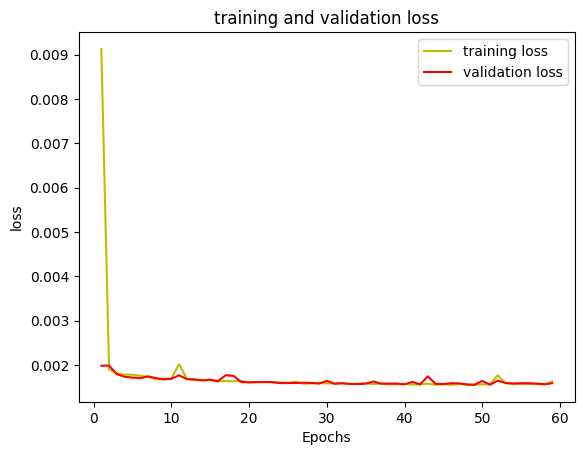

In [ ]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/Autoencoder/Results/x2/training_and_validation_loss_flickr8000.png")
plt.show()

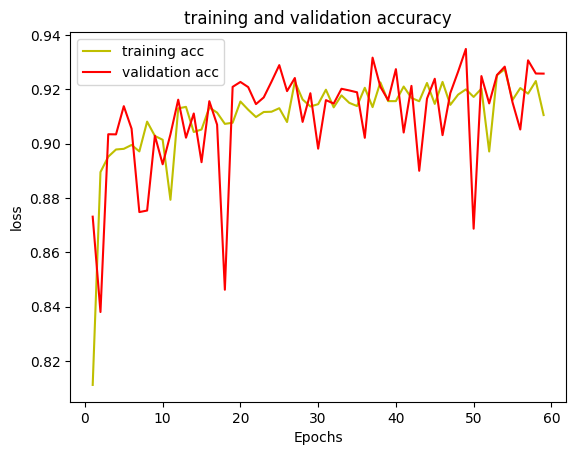

In [ ]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/Autoencoder/Results/x2/training_and_validation_accuracy_flickr8000.png")
plt.show()